<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr5/Practice5_lvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
# !unzip -qq hw3_data.zip -d dul_2021/Homework/hw5/data
# !rm hw3_data.zip
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 216 (delta 99), reused 158 (delta 53), pack-reused 0
Receiving objects: 100% (216/216), 28.70 MiB | 37.01 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=17835 sha256=590a0b846a5208ebf0dcab3f0f0a698304124905af32187a04d4b31819834d69
  Stored in directory: /tmp/pip-ephem-wheel-cache-tzhy8fna/wheels/55/59/29/0fb1c63565215773

In [2]:
%matplotlib inline

In [3]:
from dul_2021.utils.pr5_utils import *

In [4]:
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import matplotlib.pyplot as plt
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example 1: A Simple Latent Variable Model (LVM)
In this example, we train a simple LVM modeled as $z \sim \text{Multinomial}(3), x \sim N(\mu(z), diag(\sigma(z)))$, where $\mu(z)$ and $\sigma(z)$ is a trainable tensor. We fit this LVM using maximum likelhood by marginalizing out $z$.

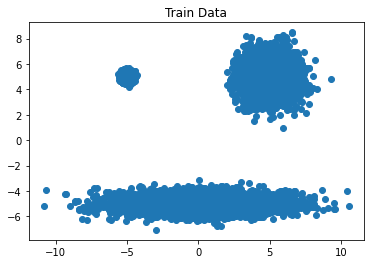

In [6]:
train_data = sample_three_blobs(10000)
test_data = sample_three_blobs(2500)
plot_scatter_2d(train_data, title='Train Data')


$\max_\theta \sum\limits_i \log p_\theta (x^{(i)}) = \max_\theta \sum\limits_i \log \sum\limits_z p(z)p_\theta (x^{(i)}|z) $

$f(x) = \frac{1}{\sqrt{2\pi }\sigma} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$

$\log f(x) = -0.5 * \log (2\pi) - \log\sigma -\frac{(x-\mu)^2}{2\sigma^2} $ 

In [10]:
class SimpleLVM(nn.Module):
    def __init__(self, k=3, d=2):
        super().__init__()
        self.k = k # number of gaussians
        self.d = d # dimension of data

        self.logit_pi = nn.Parameter(torch.zeros(k), requires_grad=True)
        self.log_s = nn.Parameter(torch.zeros(k, d), requires_grad=True)
        self.mu = nn.Parameter(torch.rand(k, d), requires_grad=True)

    def loss(self, x):
                
        # x - bs x d

        mu = self.mu.unsqueeze(1) # k x 1 x d
        log_s = self.log_s.unsqueeze(1) # k x 1 x d

        log_prob = -(x - mu) ** 2 / torch.exp(2 * log_s) / 2 # k x bs x d
        log_prob = log_prob - 0.5 * np.log(2 * np.pi) - log_s # k x bs x d
        log_prob = log_prob.sum(dim=2) # k x bs

        log_pi = F.log_softmax(self.logit_pi, dim=0)
        log_pi = log_pi.unsqueeze(1) # k x 1

        log_prob = log_prob + log_pi # k x bs

        log_prob = torch.logsumexp(log_prob, dim=0) # bs
        loss = -log_prob.mean()
        return loss

    def sample(self, n=100000):
        with torch.no_grad():
            probs = F.softmax(self.logit_pi, dim=0)
            labels = torch.multinomial(probs, n, replacement=True)
            mus, log_stds = self.mu[labels], self.log_s[labels]
            x = torch.randn(n, 2) * log_stds.exp() + mus
        return x.cpu().numpy(), labels.cpu().numpy()
    

    def fit(self, train_data, num_epochs=10, 
            lr=1e-2, batch_size=128,
            plot=False, plot_epochs=None):
        
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)        
        optim = opt.Adam(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            for x in train_loader:
                x = x.to(device).float()
                loss = self.loss(x)
                optim.zero_grad()
                loss.backward()
                optim.step()

            if plot and epoch in plot_epochs:
                self.plot(f'Epoch {epoch}')

    def plot(self, epoch):
        x, labels = self.sample(10000)
        plot_scatter_2d(x, title=f'Epoch {epoch} Samples', labels=labels)

In [16]:
model = SimpleLVM(k=4)

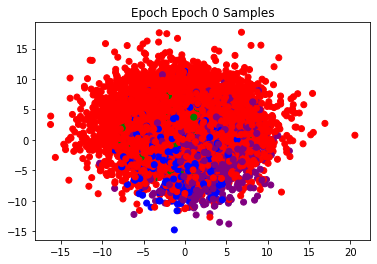

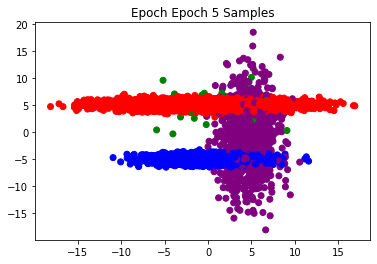

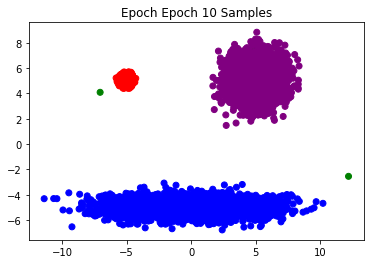

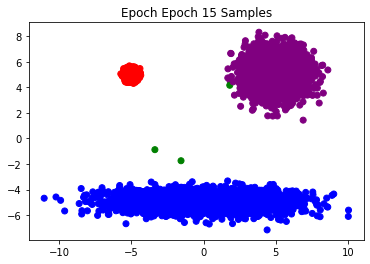

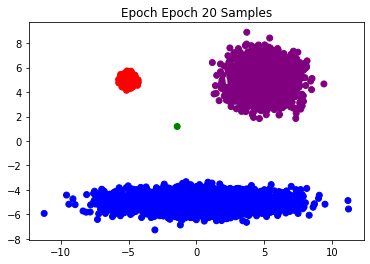

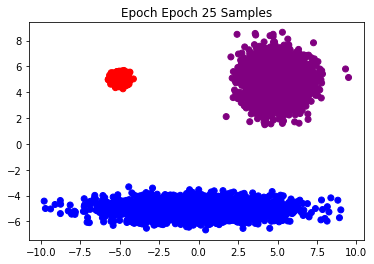

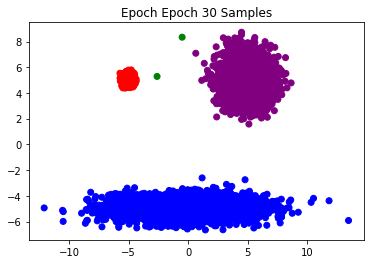

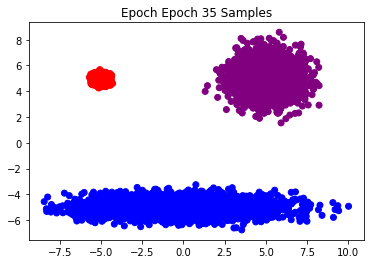

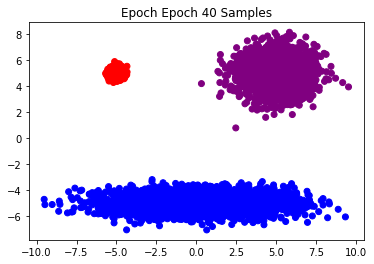

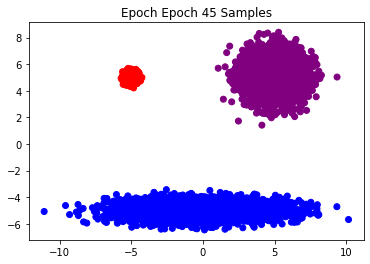

In [17]:
model.fit(train_data, plot=True, plot_epochs=np.arange(0, 100, 5), num_epochs=50, lr=5e-2)

In [18]:
F.softmax(model.logit_pi, dim=0)

tensor([3.7074e-01, 3.1456e-01, 2.0605e-05, 3.1469e-01],
       grad_fn=<SoftmaxBackward0>)

# Example 2: Likelihood Ratio Gradient vs Reparametrization trick
In this example, we compare optimizing a simple objective using the likelihood ratio gradient versus reparametrization trick. The goal is to learn the mean of a Gaussian distribution and to reach the location (5, 5).

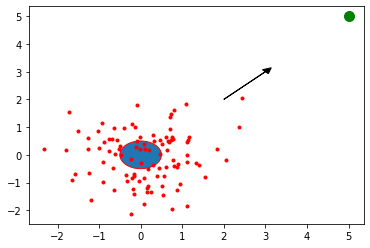

In [20]:
mean_npy = np.zeros(2)
target_mean = torch.Tensor(np.array([5, 5]))

mu_init = np.zeros(2)
popsize=100
xsamp = np.random.randn(popsize, 2) + mu_init[None]
target_point = np.array([5., 5.])
plt.clf()
plt.plot(xsamp[:, 0], xsamp[:, 1], 'r.', label='samp')
plt.plot(target_point[0], target_point[1], 'g.', ms=20, label='target_samp')
el = Ellipse(xy=mu_init, width=2*0.5, height=2*0.5, angle=0)
el.set_edgecolor('red')
plt.arrow(2, 2, 1, 1, head_width=.2, head_length=.2, fc='k', ec='k')
plt.gca().add_artist(el)
plt.show()

In [30]:
class OptEx(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = nn.Parameter(torch.zeros(2), requires_grad=True)
    
    def loss(self, n_samples):
        raise NotImplementedError()
    
    def fit(self, lr=1e-1, num_epochs=20, n_samples=1):

        optim = opt.SGD(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            loss = self.loss(n_samples)
            optim.zero_grad()
            loss.backward()
            optim.step()
            self.plot()
    
    def plot(self):
        with torch.no_grad():
            plt.clf()
            plt.plot(target_point[0], target_point[1], 'g.', ms=20, label='target_samp')
            el = Ellipse(xy=self.mu.numpy(), width=2*0.5, height=2*0.5, angle=0)
            el.set_edgecolor('red')
            plt.gca().add_artist(el)
            plt.axis([-10, 10, -10, 10])
            plt.show()

$\nabla E_{z\sim q_\theta(x)}f(z) \sim \nabla E_{z\sim q_\theta(x)}\log q_\theta(z)f(z)$

This technique also applied in reinforcement learning. You can see how it works in great detail here https://how.rl.works/

In [31]:
class LRG(OptEx):
    def __init__(self, baseline):
        super().__init__()
        self.baseline = baseline

    def loss(self, n_samples):
        samples = torch.distributions.Normal(self.mu, 1).sample((n_samples, )).detach()
        loss = torch.sum((samples - target_mean)**2, dim=1)
        if self.baseline:
            loss -= loss.mean()
        
        log_q = -((self.mu - samples) ** 2).sum(dim=1) / 2
        
        loss = log_q * loss
        return loss.mean()

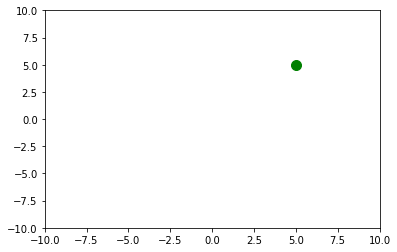

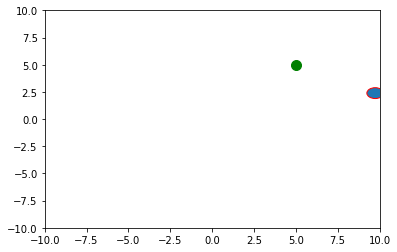

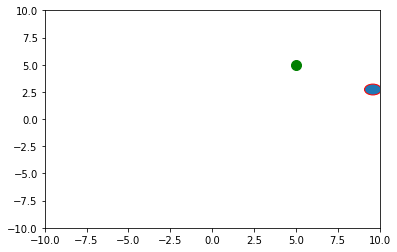

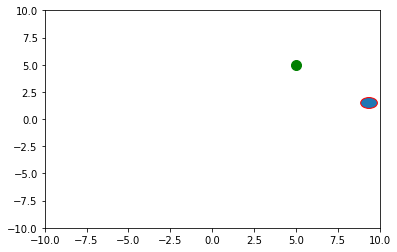

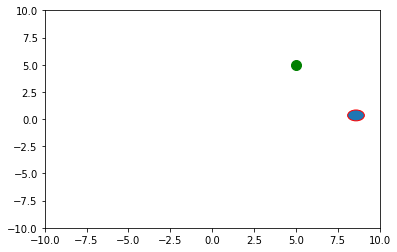

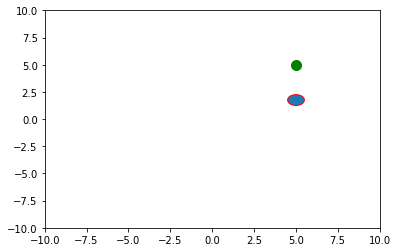

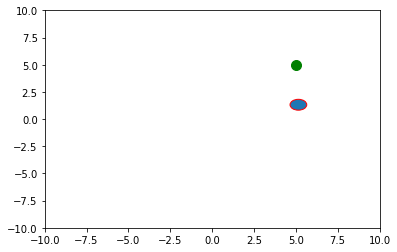

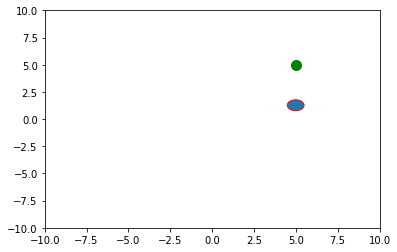

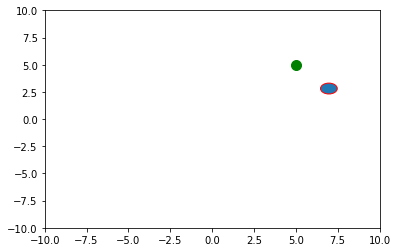

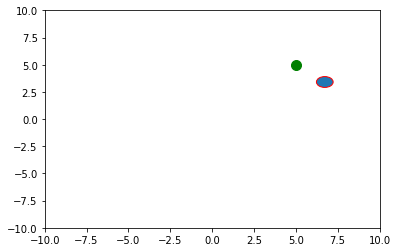

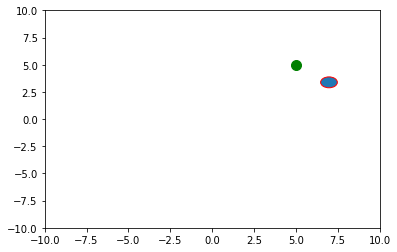

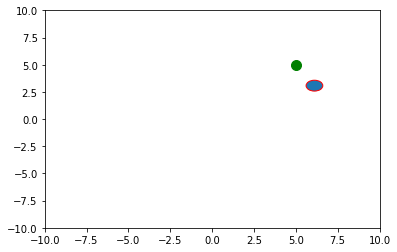

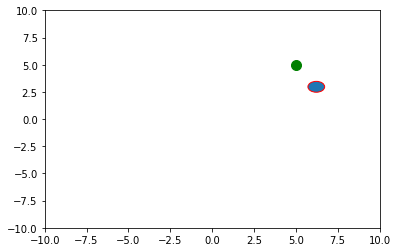

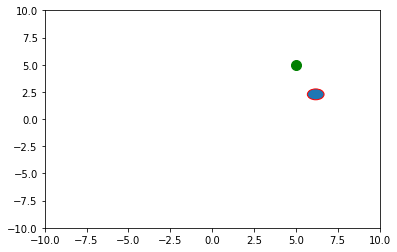

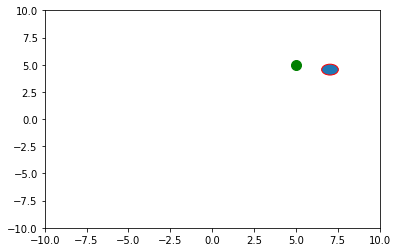

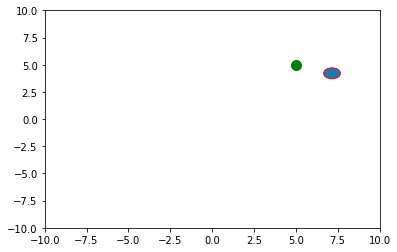

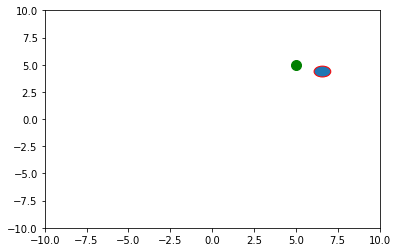

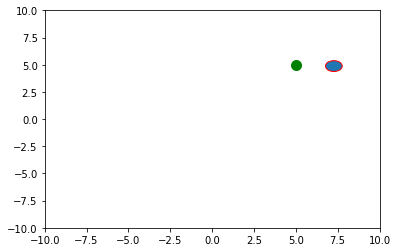

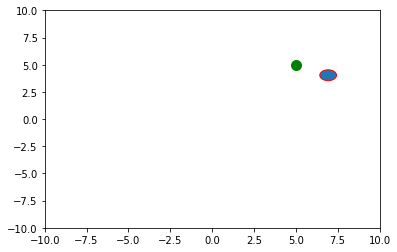

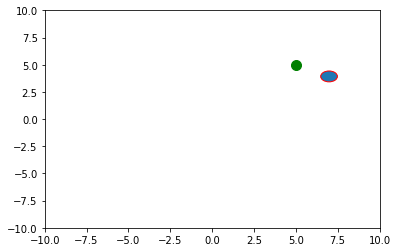

In [34]:
model = LRG(False)
model.fit(num_epochs=20, n_samples=2)

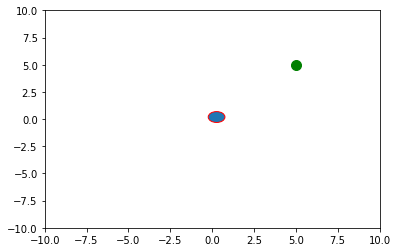

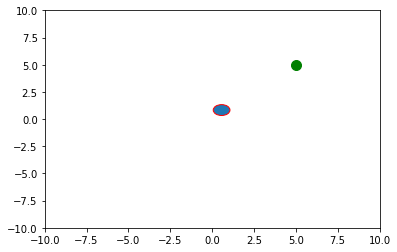

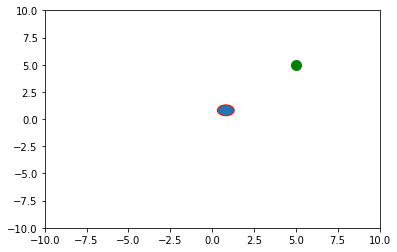

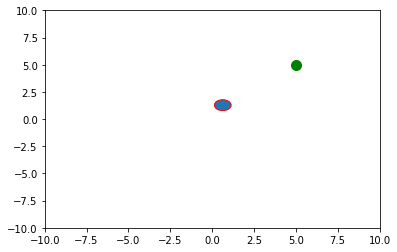

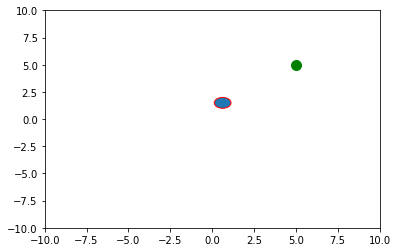

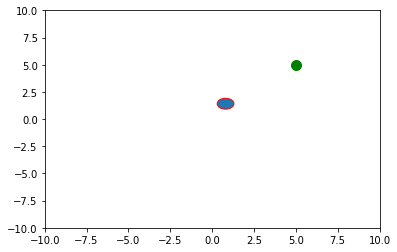

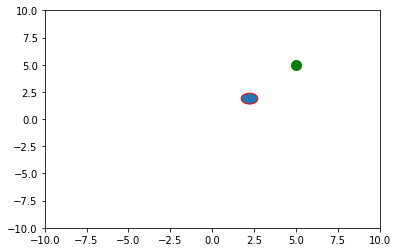

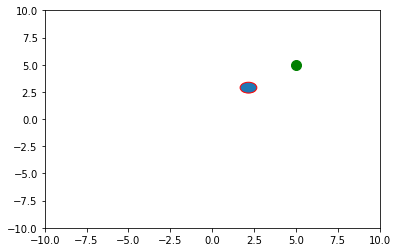

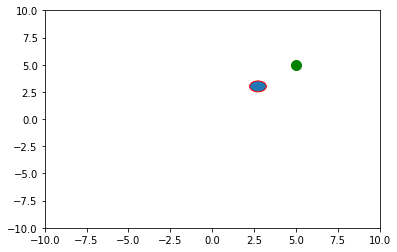

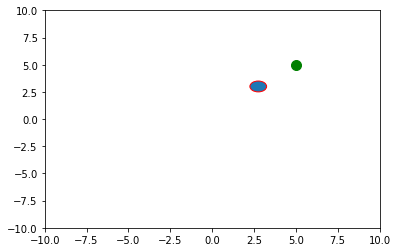

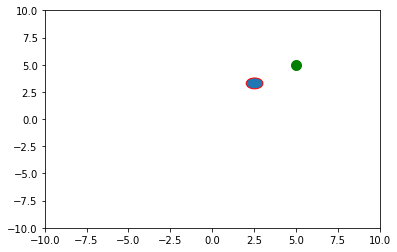

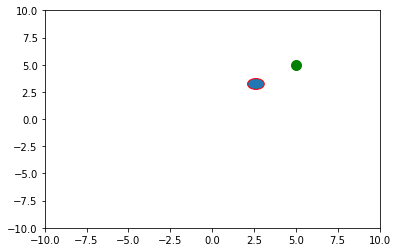

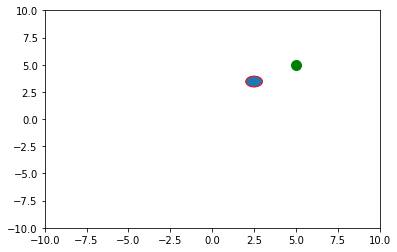

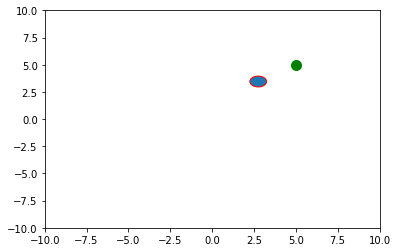

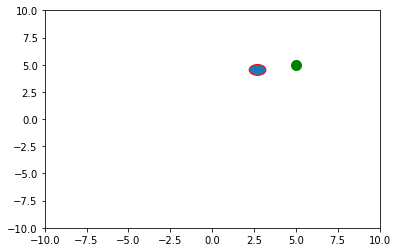

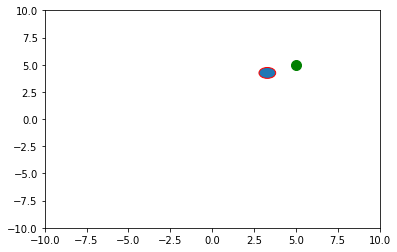

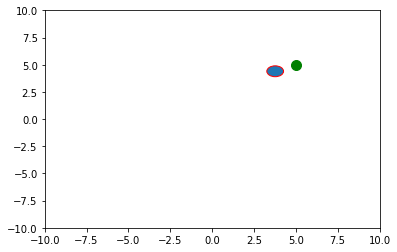

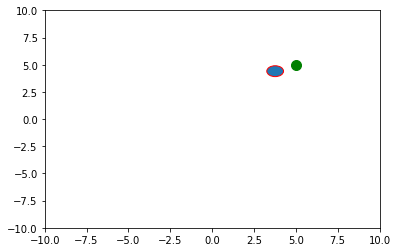

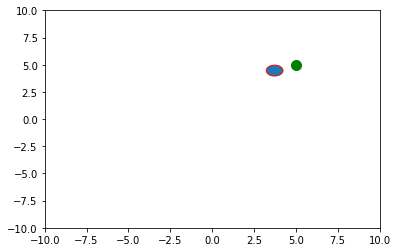

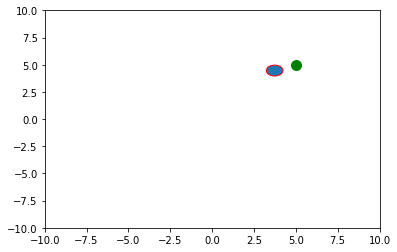

In [35]:
model = LRG(True)
model.fit(num_epochs=20, n_samples=2)

In [36]:
class RT(OptEx):
    def loss(self, n_samples):
        samples = torch.distributions.Normal(torch.zeros_like(self.mu), 1).sample((n_samples, )) + self.mu
        loss = torch.sum((samples- target_mean)**2, dim=1)
        loss = loss
        return loss.mean()

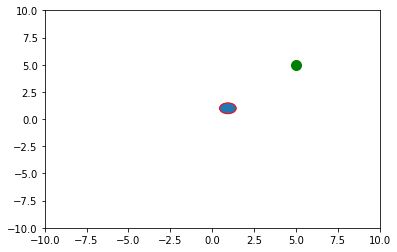

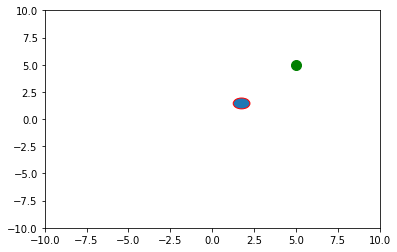

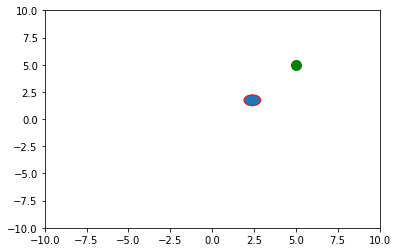

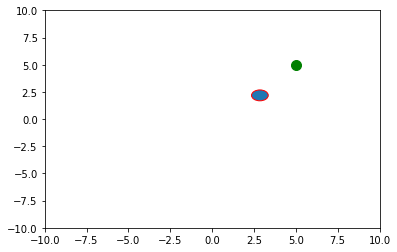

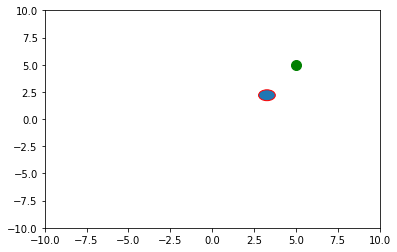

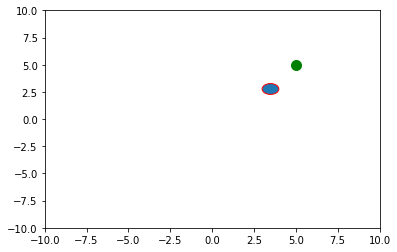

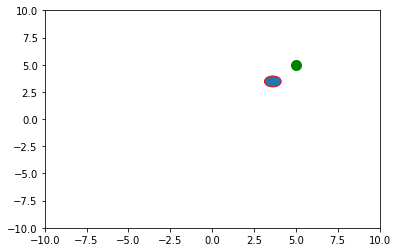

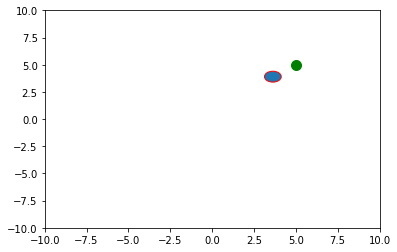

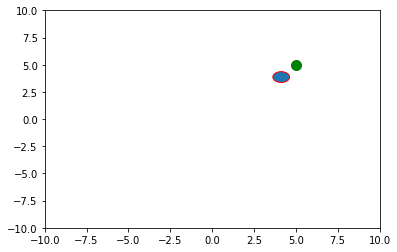

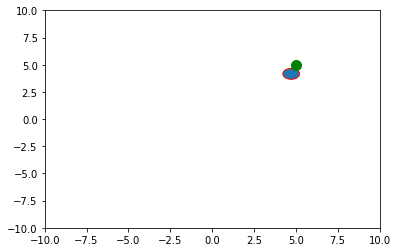

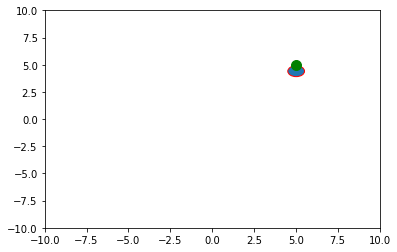

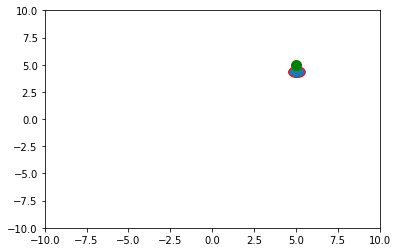

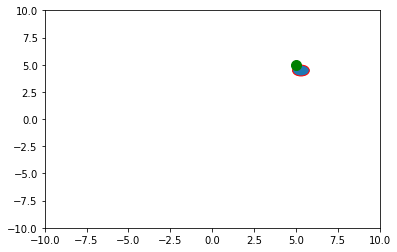

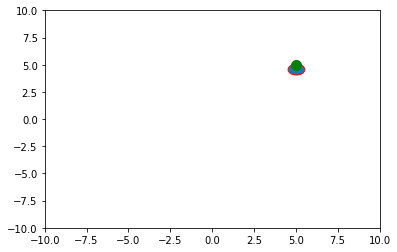

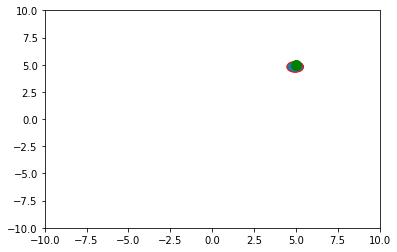

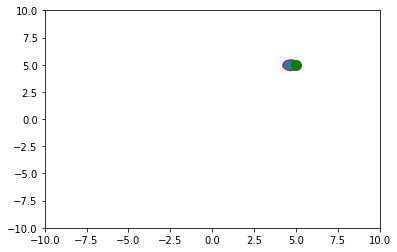

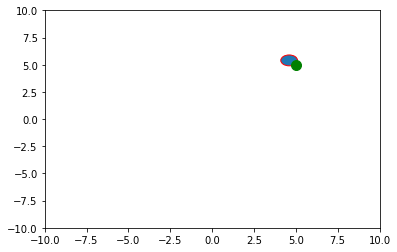

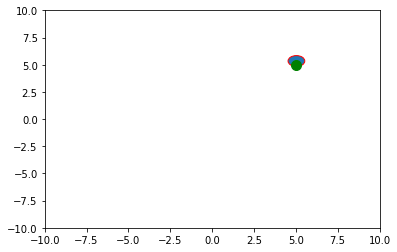

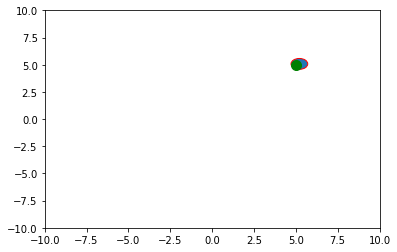

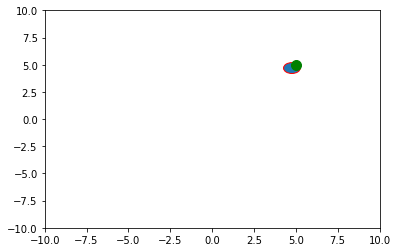

In [37]:
model = RT()
model.fit(num_epochs=20, n_samples=1)

# Example 3: VAE on 2d Data

Here we will train a simple VAE on 2D data.

Dataset 1


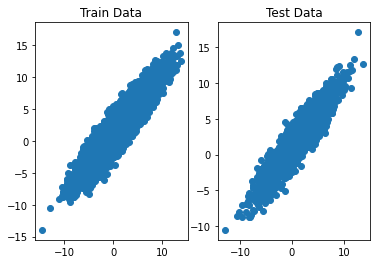

Dataset 2


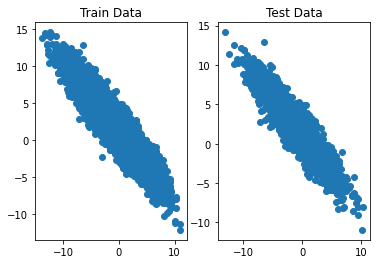

In [8]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

$$KL(N(\mu_1, \sigma_1)|N(\mu_2, \sigma_2)) = \log \frac{\sigma_2}{\sigma_1} - 0.5 + \frac{\sigma_1^2 + (\mu_1-\mu_2)^2}{2\sigma_2^2}$$

$$ELBO = E_{z\sim q(z)} [-\log q(z) + \log p(z) + \log(p|x)] =  E_{z\sim q(z)} \log(p|x) - E_{z\sim q(z)} \log \frac{q_z}{p_z} = E_{z\sim q(z)} \log(p|x) - KL(q(z)|p(z))$$

In [27]:
class VAE2d(nn.Module):
    def __init__(self, hd=64):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(2, hd), 
                                     nn.ReLU(),
                                     nn.Linear(hd, hd), 
                                     nn.ReLU(), 
                                     nn.Linear(hd, 4))

        self.decoder = nn.Sequential(nn.Linear(2, hd), 
                                     nn.ReLU(),
                                     nn.Linear(hd, hd), 
                                     nn.ReLU(),
                                     nn.Linear(hd, 4))
        
    
    
    def loss(self, x):
        mu_z, log_sig_z = self.encoder(x).split(2, dim=1)

        z_sample = Normal(0, 1).sample(mu_z.shape) * log_sig_z.exp() + mu_z

        mu_x, log_sig_x = self.decoder(z_sample).split(2, dim=1)

        log_prob = -log_sig_x - 0.5 * (x - mu_x) **2 / (2 * log_sig_x).exp() 

        kl = 0.5 * (torch.exp(2 * log_sig_z) + mu_z ** 2)  - log_sig_z - 0.5

        return -log_prob.mean(), kl.mean()

    def sample(self, n=1000, noise=True):
        z = Normal(0, 1).sample((2 * n,)).view(-1, 2)
        mu_x, log_sig_x = self.decoder(z).split(2, dim=1)
        if noise:
            x = Normal(0, 1).sample((2 * n,)).view(-1, 2) * log_sig_x.exp() + mu_x
        else:
            x = mu_x
        return x.cpu().detach().numpy()
    
    def test(self, testloader):
        loss = 0
        tl = 0
        kl = 0
        log_prob = 0
        with torch.no_grad():
            for batch in testloader:
                lp, kl_b = self.loss(batch)
                loss += (lp + kl_b) * batch.shape[0]
                kl += kl_b * batch.shape[0]
                log_prob += lp * batch.shape[0]
                tl += batch.shape[0]
        return np.array([loss / tl, log_prob / tl, kl / tl])

    def fit(self, train_data, test_data, lr=1e-3, num_epochs=100, bs=256):
        trainloader = torch.utils.data.DataLoader(train_data,
                                                  batch_size=bs, 
                                                  shuffle=True)
        
        testloader = torch.utils.data.DataLoader(test_data, 
                                                 batch_size=bs)

        optim = opt.Adam(self.parameters(), lr=lr)
        
        train_loss = None
        test_loss = self.test(testloader)
        for epoch in range(num_epochs):
            

            for batch in trainloader:
                lp, kl = self.loss(batch)
                loss = lp + kl
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                if train_loss is None:
                    train_loss = np.array([loss.cpu().detach().numpy(),
                                           kl.cpu().detach().numpy(),
                                           lp.cpu().detach().numpy()])
                else:
                    train_loss = np.vstack((train_loss,
                                           np.array([loss.cpu().detach().numpy(),
                                           kl.cpu().detach().numpy(),
                                           lp.cpu().detach().numpy()])))
            
            test_loss = np.vstack((test_loss, self.test(testloader)))
        
        return train_loss, test_loss

In [19]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    model =  VAE2d(128)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=100, lr=1e-3)
    sample1 = model.sample(noise=True)
    sample2 = model.sample(noise=False)
    return train_loss, test_loss, sample1, sample2

Final -ELBO: 1.8049, Recon Loss: 0.4884, KL Loss: 1.3165


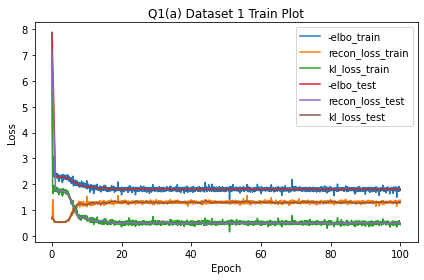

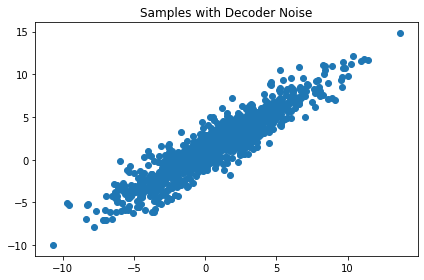

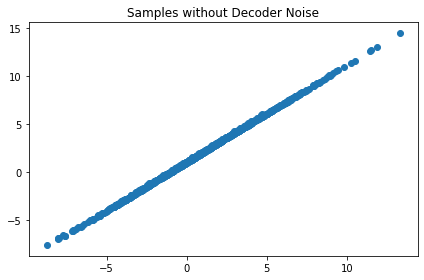

In [25]:
q1_save_results('a', 1, q1)

Final -ELBO: 1.8030, Recon Loss: 0.4767, KL Loss: 1.3263


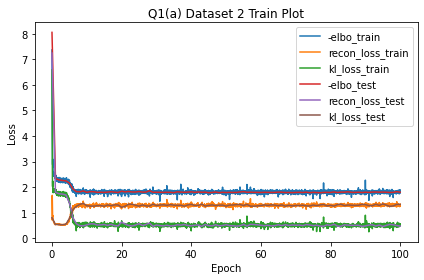

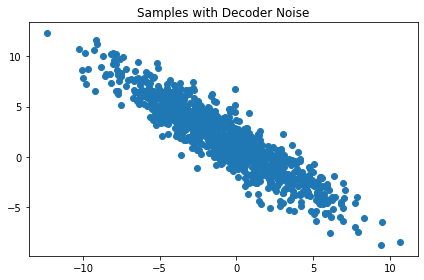

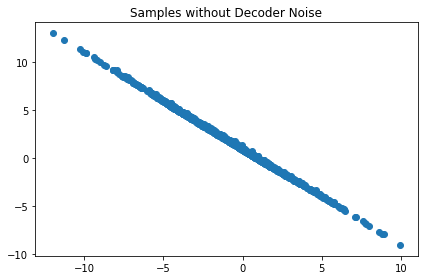

In [26]:
q1_save_results('a', 2, q1)